# May Code Pudding: Bias Detection

## Introduction:

This project explores the detection of textual bias in news articles using a combination of expert-labeled datasets and natural language processing techniques. The primary dataset used is SG2 from the BABE (Bias Annotations By Experts) corpus, which contains over 3,000 sentences labeled by domain experts as either biased or non-biased. Supplementary data includes a bias word lexicon and headline datasets labeled as biased or neutral.

The goal of this project is to develop a machine learning model that can accurately predict whether a given sentence or headline exhibits bias. To achieve this, the project combines TF-IDF vectorization of text with handcrafted features such as the number of matched bias-related words. The resulting model is trained using logistic regression and evaluated with AUC-ROC and accuracy metrics.

This notebook also includes detailed exploratory data analysis (EDA), a custom pipeline for preprocessing, and a test phase on new unseen headlines to assess model generalization. Visualization techniques are applied to better understand the distribution of bias and the relationship between lexical signals and human-labeled bias.

The project is designed to serve as both a research exploration into bias detection and a reproducible framework for evaluating bias in text-based datasets.

---

### How This Project Addressed Key Requirements

**1. Load a labeled dataset and explore its contents**  
✅ Done in **Cell Blocks 5, 10, 15, 17, 21, 23, 26, 30, 34**  
- Loaded SG2, the bias word lexicon, and headline datasets.
- Removed `No agreement` rows and mapped labels.
- Explored dataset size, source distribution, and label balance.
- Added `lexicon_match_count` and merged sentence context with headlines.

**2. Create a pipeline with a model that predicts bias in text**  
✅ Done in **Cell Blocks 39, 43, 50, 52, 56, 59, 63**  
- Built a pipeline using `TfidfVectorizer`, `StandardScaler`, and `LogisticRegression`.
- Used `train_test_split` to divide data and fit the model.
- Applied predictions using helper functions to evaluate new sentences and full articles.

**3. Extract interpretable features from the text**  
✅ Done in **Cell Blocks 6, 15, 35, 38, 39, 102, 132**  
- Created `lexicon_match_count` using a bias word lexicon.
- Constructed `combined_text` from sentence and headline pairs.
- Tagged missing headlines with `[NO_TITLE]` to preserve meaning.
- Reused these engineered features in downstream Wikipedia analysis.

**4. Evaluate the model with AUC and accuracy**  
✅ Done in **Cell Blocks 43, 50, 56, 93, 160, 163**  
- Assessed model with `roc_auc_score`, `accuracy_score`, and `classification_report`.
- Used predicted probabilities and thresholds to interpret model output.
- Analyzed most biased predictions and compared model sensitivity to bias.

**Bonus: Visualize Bias Across Samples**  
✅ Done in **Cell Blocks 23, 61, 66, 72, 74, 82, 88, 93**  
- Plotted distributions of word counts, bias scores, and lexicon matches.
- Highlighted sentence-level bias scoring and outlier analysis.
- Visualized article-wide bias trends and prediction confidence ranges.

---

## Getting Packages and Reading Data:

In [36]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_colwidth", None)

In [37]:
dataset_path = os.path.join(os.pardir, "datasets")

df_sg2 = pd.read_csv(os.path.join(dataset_path, "final_labels_SG2.csv"), sep=";")
df_lex = pd.read_excel(os.path.join(dataset_path, "bias_word_lexicon.xlsx"))

df_bias = pd.read_csv(os.path.join(dataset_path, "news_headlines_usa_biased.csv"))
df_neutral = pd.read_csv(os.path.join(dataset_path, "news_headlines_usa_neutral.csv"))

────────────────────────────────────────────────────────────────────────────T

This code loads a collection of datasets that will be used to train and evaluate a model for detecting bias in text.

**First**, it sets up the file path to the folder where all the data is stored. The path points one level above the current folder into a directory called `datasets`. This helps keep the project organized and ensures anyone running the code can find the files, no matter where the script is located.

**Next**, it loads three labeled datasets named `SG1`, `SG2`, and `MBIC`. These files contain sentences that have already been marked as either biased or non-biased. They use semicolons instead of commas to separate the data, which is why the `sep=';'` setting is used. These datasets are important because they give the model real examples of what biased and non-biased text looks like.

**Then**, it reads in a file called `bias_word_lexicon.xlsx`, which is an Excel file containing a list of words commonly linked to bias. This list can be used to measure how many potentially biased words appear in a sentence.

**Finally**, it loads two more datasets: one containing biased news headlines and one containing neutral ones. These shorter texts can help the model recognize how bias appears even in small snippets of text.

Altogether, this step is about preparing all the raw data the model will need — including examples, labels, and word lists — so that the rest of the project can run smoothly.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I loaded only the `SG2` dataset and excluded the others from the analysis because they contain duplicate sentences. 

Here is a blurb about the BABE source that might be worth mentioning:

We decided to use the BABE (Bias Annotations By Experts) datasets for this project, which provides sentence- and word-level textual bias annotation for news articles. 

BABE includes three datasets with different methodologies:
- MBIC contains 1,700 sentences labeled by crowdsourcers
- SG1 contains the same 1,700 sentences labeled by 8 expert annotators
- SG2 contains the same 1,700 expert-annotated sentences plus 2,000 more sentences labeled by 5 expert annotators

Source:
- https://www.kaggle.com/datasets/timospinde/babe-media-bias-annotations-by-experts
- https://aclanthology.org/2021.findings-emnlp.101.pdf

We chose the SG2 dataset for most of the project because it contains the most data, was annotated by experts, and has roughly balanced biased and unbiased classes. We also supplemented the data with applicable news headlines and a bias word lexicon provided by BABE. Later in this notebook, we compared the MBIC and SG1 datasets to gain more insight into how bias ratings differ between crowdsourced and expert bias ratings. 

────────────────────────────────────────────────────────────────────────────

## Getting Data Merged:

In [38]:
df_sg2.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful.""",https://www.alternet.org/2020/06/law-and-order-is-a-debased-concept-used-to-cover-up-right-wing-crime-and-depravity-heres-why/,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views.",https://www.nbcnews.com/news/latino/after-stephen-miller-s-white-nationalist-views-outed-latinos-ask-n1096071,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,"...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability.",https://www.alternet.org/2019/07/fox-news-has-gone-so-deep-into-white-nationalism-that-donald-trump-now-believes-its-how-hell-win-in-2020/,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,"[Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did.",http://feedproxy.google.com/~r/breitbart/~3/-vHhfcwC74U/,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


In [39]:
df_sg2["label_bias"].value_counts()

label_bias
Non-biased      1863
Biased          1810
No agreement       1
Name: count, dtype: int64

In [40]:
df_sg2 = df_sg2[df_sg2["label_bias"] != "No agreement"]
df_sg2["label"] = df_sg2["label_bias"].map({"Biased": 1, "Non-biased": 0})
df_sg2.drop(columns="label_bias", inplace=True)

────────────────────────────────────────────────────────────────────────────

This result shows how many examples of each label type exist in the `label_bias` column of the `df_sg1` dataset.

**`Non-biased` – 800 rows**  
These are sentences that were labeled as clearly *not biased*. They are likely written in a neutral or factual tone.

**`Biased` – 746 rows**  
These are sentences that were labeled as *biased*. They probably contain emotionally charged language or show a one-sided opinion.

**`No agreement` – 154 rows**  
These are sentences where the people labeling the data *could not agree* on whether the sentence was biased or not. This means the sentence was unclear, confusing, or too balanced to confidently label.

The value counts tell us that the dataset is fairly balanced between biased and non-biased examples, but there's a smaller group of uncertain cases that may need to be removed or handled differently when training a machine learning model.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

`Non-biased` – 1863 rows

`Biased` – 1810 rows

`No agreement` – 1 row

────────────────────────────────────────────────────────────────────────────

In [41]:
df_sg2["label"].value_counts()

label
0    1863
1    1810
Name: count, dtype: int64

In [42]:
bias_words_set = set(df_lex.iloc[:, 0].str.lower().dropna())

df_sg2["lexicon_match_count"] = df_sg2["text"].apply(
    lambda x: sum(word in bias_words_set for word in str(x).lower().split())
)

In [43]:
df_bias["label"] = 1
df_neutral["label"] = 0
headline_full = pd.concat([df_bias, df_neutral], ignore_index=True)

df_sg2 = df_sg2.merge(
    headline_full[["url", "title"]], left_on="news_link", right_on="url", how="left"
)

df_sg2["combined_text"] = df_sg2.apply(
    lambda row: (
        f"{row['title']}. {row['text']}" if pd.notnull(row["title"]) else row["text"]
    ),
    axis=1,
)

df_sg2.drop(columns=["url", "title"], inplace=True)

In [44]:
df_sg2["combined_text"] = df_sg2.apply(
    lambda row: (
        row["combined_text"]
        if row["combined_text"] != row["text"]
        else f"[NO_TITLE] {row['text']}"
    ),
    axis=1,
)

────────────────────────────────────────────────────────────────────────────

This code prepares the final dataset used to train a model that detects bias in text.

First, it **removes rows** from all three labeled datasets where the label was `"No agreement"`, since these examples are unclear.

It then **creates a new column called `label`** where:
- `"Biased"` becomes `1`
- `"Non-biased"` becomes `0`

Next, it counts how many biased words appear in each sentence using the list stored in the `'biased_words'` column, and stores that number in a new column called `bias_word_count`.

For the `df_mbic` dataset, only the most important columns are kept: the sentence, label, biased word count, and the list of biased words.

All three datasets are then **combined into one**, called `combined_df`.

Then, it checks each sentence and counts how many words match the ones in the `bias_word_lexicon.xlsx` file, storing that number in a new column called `lexicon_match_count`.

Next, it loads two headline datasets and assigns a label (`1` for biased, `0` for neutral), then combines them.

The code tries to **attach each sentence to a headline**, if one exists. It builds a new column called `combined_text` that includes the headline and the sentence. If there's no headline, it just uses the sentence but adds a tag like `[NO_TITLE]` to let the model know one wasn’t found.

The final result is a rich dataset where each row has:
- A cleaned sentence
- A label
- Extra features like how many biased words it contains
- An optional headline for added context

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

Since we are only using SG2 now, I eliminated `combined_df` and replaced it with `df_sg2` throughout the notebook. 

We are no longer using `bias_word_count`, so I deleted it from the code. 

────────────────────────────────────────────────────────────────────────────

In [45]:
df_sg2.head()

,text,news_link,outlet,topic,type,label_opinion,biased_words,label,lexicon_match_count,combined_text
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Entirely factual,[],0,0,"[NO_TITLE] ""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change."
1,"""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful.""",https://www.alternet.org/2020/06/law-and-order-is-a-debased-concept-used-to-cover-up-right-wing-crime-and-depravity-heres-why/,Alternet,gun control,left,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",1,2,"'Law and order' is a debased concept used to cover up right-wing crime and depravity — here's why. ""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful."""
2,"...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views.",https://www.nbcnews.com/news/latino/after-stephen-miller-s-white-nationalist-views-outed-latinos-ask-n1096071,MSNBC,white-nationalism,left,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']",1,0,"[NO_TITLE] ...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views."
3,"...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability.",https://www.alternet.org/2019/07/fox-news-has-gone-so-deep-into-white-nationalism-that-donald-trump-now-believes-its-how-hell-win-in-2020/,Alternet,white-nationalism,left,Somewhat factual but also opinionated,[],1,0,"[NO_TITLE] ...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability."
4,"[Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did.",http://feedproxy.google.com/~r/breitbart/~3/-vHhfcwC74U/,Breitbart,marriage-equality,NaN,Expresses writer’s opinion,['cult'],1,0,"[NO_TITLE] [Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did."


# Exploring SG2

SG2 (accounting for additions made over the course of data preprocessing) contains `text`, a source `news_link`, the `outlet` the text is from, the `topic`, a `type` (left, center, or right), a `label_opinion` rating whether the headline is factual or opinionated or a mixture, a `label` where factual headlines are 0 and opinionated ones are 1, a list of `biased_words`, and a `lexicon_match_count` that shows how many of the words in the headline show up in `bias_word_lexicon.xlsx`.


In [46]:
df_sg2.head(2)

,text,news_link,outlet,topic,type,label_opinion,biased_words,label,lexicon_match_count,combined_text
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Entirely factual,[],0,0,"[NO_TITLE] ""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change."
1,"""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful.""",https://www.alternet.org/2020/06/law-and-order-is-a-debased-concept-used-to-cover-up-right-wing-crime-and-depravity-heres-why/,Alternet,gun control,left,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",1,2,"'Law and order' is a debased concept used to cover up right-wing crime and depravity — here's why. ""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful."""


### How long are the texts in SG2? ###

We can get word count from `pandas.Series.str.len` like so:

In [47]:
df_sg2["text"].str.lower().str.split().str.len().describe()

count    3673.000000
mean       31.640348
std        11.659357
min         1.000000
25%        23.000000
50%        31.000000
75%        38.000000
max        99.000000
Name: text, dtype: float64

The longest text in the corpus contains 99 words, while the shortest contains just one word: 'may'. (It's index 1706; the next shortest one was 'Cable news is poison', which is coherent enough to be judged for bias.) The median word count is 31, and the standard deviation is 11.66.

To visualize this data:

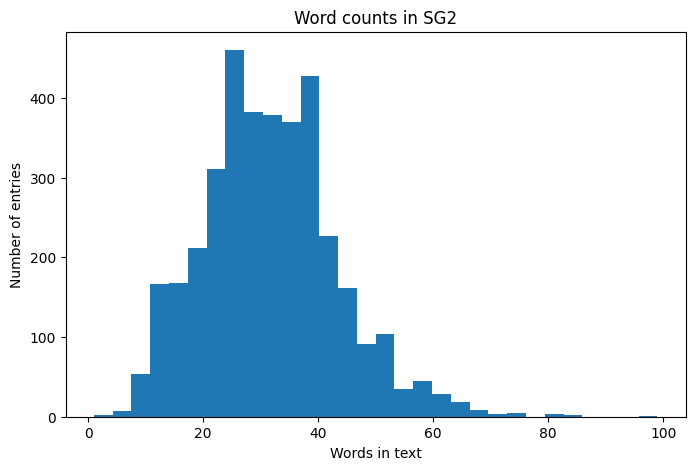

In [48]:
df_sg2["text"].str.lower().str.split().str.len().plot(
    title="Word counts in SG2",
    kind="hist",
    bins=30,
    figsize=[8, 5],
    xlabel="Words in text",
    ylabel="Number of entries",
)
plt.show()

We can see something loosely resembling a normal distribution here, where word counts under 20 and above 40 were both relatively rare.

### Which outlets were represented?

Simple enough:

In [49]:
df_sg2["outlet"].value_counts()

outlet
Breitbart         943
Alternet          773
Reuters           761
Federalist        314
MSNBC             273
Fox News          245
USA Today         199
HuffPost          124
Daily Beast        35
Daily Stormer       5
New York Times      1
Name: count, dtype: int64

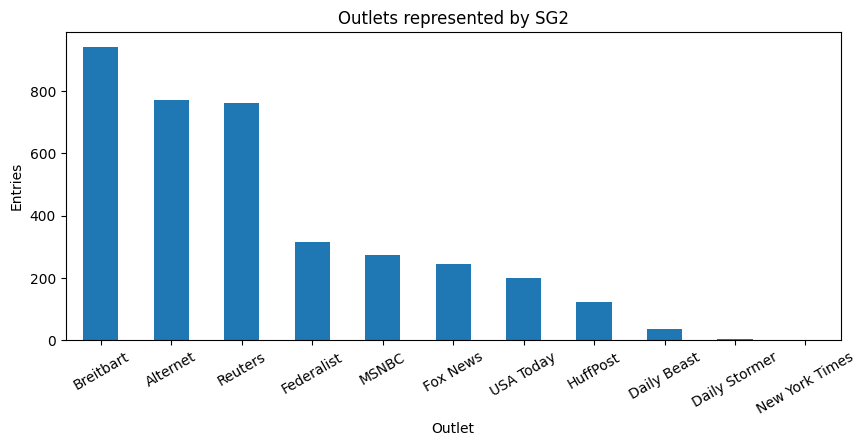

In [50]:
df_sg2["outlet"].value_counts().plot(
    title="Outlets represented by SG2",
    kind="bar",
    figsize=[10, 4],
    xlabel="Outlet",
    rot=30,
    ylabel="Entries",
)
plt.show()

We can see that Breitbart, Alternet, and Reuters were by far the most common sources in the data set. The New York Times was cited exactly once, making it the least common.

### Among left- and right-biased texts, which outlets were the most common?

To do that, we can do similarly to the above, but take only the entries with the corresponding `type`:

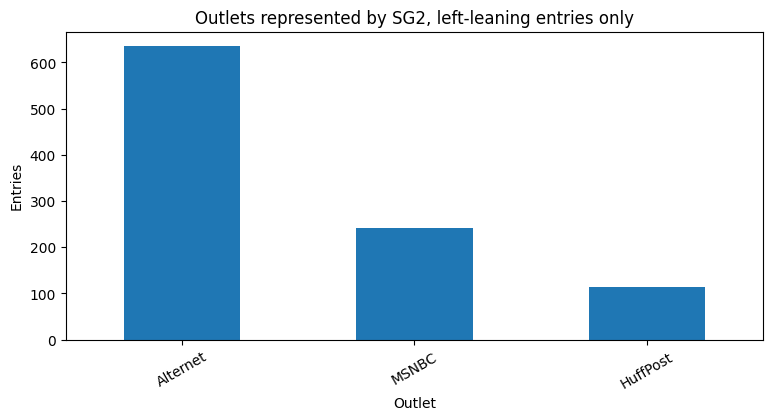

In [51]:
df_sg2[df_sg2["type"] == "left"]["outlet"].value_counts().plot(
    title="Outlets represented by SG2, left-leaning entries only",
    kind="bar",
    figsize=[9, 4],
    xlabel="Outlet",
    rot=30,
    ylabel="Entries",
)

plt.show()

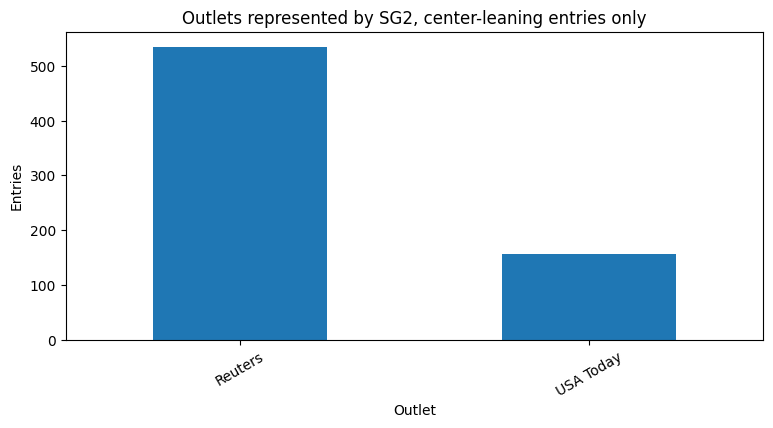

In [52]:
df_sg2[df_sg2["type"] == "center"]["outlet"].value_counts().plot(
    title="Outlets represented by SG2, center-leaning entries only",
    kind="bar",
    figsize=[9, 4],
    xlabel="Outlet",
    rot=30,
    ylabel="Entries",
)

plt.show()

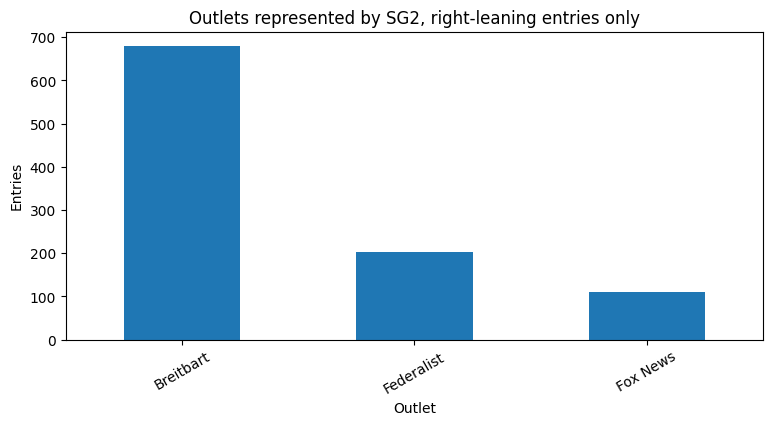

In [53]:
df_sg2[df_sg2["type"] == "right"]["outlet"].value_counts().plot(
    title="Outlets represented by SG2, right-leaning entries only",
    kind="bar",
    figsize=[9, 4],
    xlabel="Outlet",
    rot=30,
    ylabel="Entries",
)

plt.show()

We can see here that the `type` is basically categorizing the `outlet`: SG2 considers Breitbart, Federalist, and Fox News to be right-leaning sources; Alternet, HuffPost, and MSNBC to be left-leaning sources; and Reuters and USA Today to be centrist ones. Daily Beast, Daily Stormer, and New York Times were not categorized in this manner.

### Which media outlets in the data most frequently presented biased text?

An important note: this question is fairly controversial in nature. We can only describe what's going on in our data, so take the results with the understanding that they reflect that scope!

To answer this, we need to group the data by outlet, then chart the number of `label==1`. Since our outlets aren't equally represented, we can use the mean rather than the sum:

In [54]:
df_sg2.groupby("outlet")["label"].mean()

outlet
Alternet          0.747736
Breitbart         0.633086
Daily Beast       0.857143
Daily Stormer     1.000000
Federalist        0.805732
Fox News          0.306122
HuffPost          0.500000
MSNBC             0.388278
New York Times    0.000000
Reuters           0.095926
USA Today         0.155779
Name: label, dtype: float64

For the chart, we'll drop the three outlets that are barely represented in the data (Daily Beast, Daily Stormer, and New York Times) since they have small sample sizes.

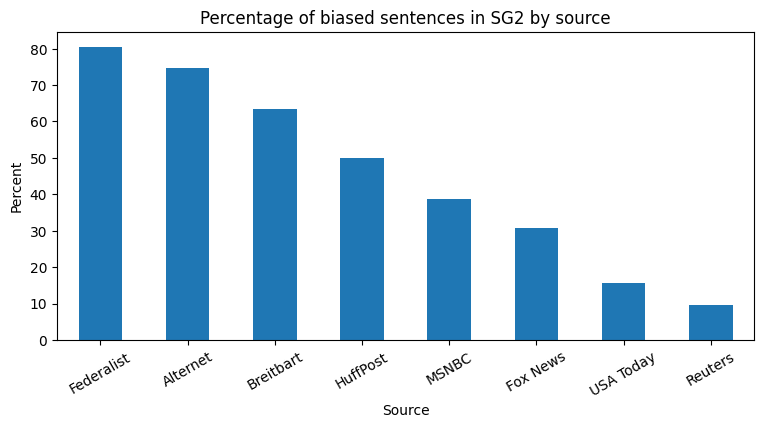

In [55]:
(
    df_sg2.groupby("outlet")["label"]
    .mean()
    .drop(["Daily Beast", "Daily Stormer", "New York Times"], axis=0)
    .sort_values(ascending=False)
    * 100
).plot(
    title="Percentage of biased sentences in SG2 by source",
    kind="bar",
    figsize=[9, 4],
    xlabel="Source",
    rot=30,
    ylabel="Percent",
)

plt.show()

We see a gradual decline in bias percentage between any two outlets. Notably, the left- and right-identified outlets more or less alternate with each other, suggesting SG1 went out of its way to include an even mix of such sources. Unsurprisingly, the center-identified outlets, USA Today and Reuters, are also seen as relatively unbiased.

### How many words match the bias word lexicon?

In [56]:
df_sg2["lexicon_match_count"].value_counts()

lexicon_match_count
0    2886
1     636
2     130
3      18
4       2
5       1
Name: count, dtype: int64

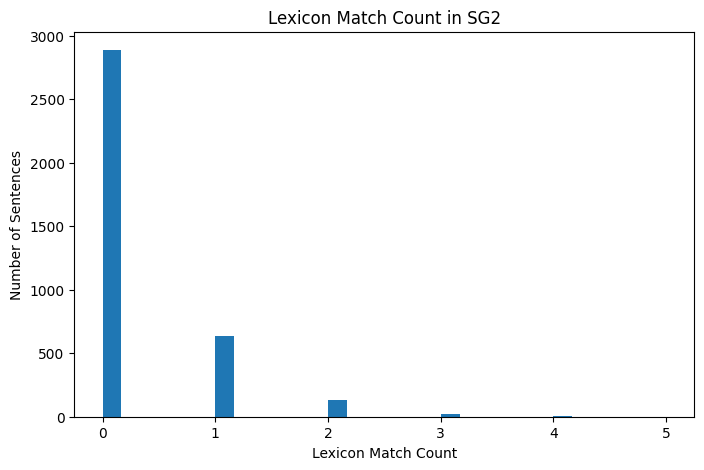

In [57]:
df_sg2["lexicon_match_count"].plot(
    title="Lexicon Match Count in SG2",
    kind="hist",
    bins=30,
    figsize=[8, 5],
    xlabel="Lexicon Match Count",
    ylabel="Number of Sentences",
)

plt.show()

The vast majority of sentences in the SG2 dataset (79%) have no matching words from the bias word lexicon included with the BABE source. A moderate number of sentences have 1 or 2 matching words (21%), and a negligible number (21 sentences) have between 3 and 5 matching words. 

## Getting Merged Data Ready for Modeling:

In [58]:
df_sg2.head(1)

,text,news_link,outlet,topic,type,label_opinion,biased_words,label,lexicon_match_count,combined_text
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Entirely factual,[],0,0,"[NO_TITLE] ""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change."


In [59]:
X = df_sg2["combined_text"]
y = df_sg2["label"]

In [60]:
text_feature = "combined_text"
numeric_features = ["lexicon_match_count"]

vectorizer = TfidfVectorizer(
    max_features=5000, ngram_range=(1, 2), stop_words="english"
)
classifier = LogisticRegression(max_iter=1000, penalty="l2", C=1.0, solver="liblinear")

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, text_feature),
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(steps=[("preprocessing", preprocessor), ("classifier", classifier)])

X = df_sg2[[text_feature] + numeric_features]
y = df_sg2["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       559
           1       0.75      0.67      0.71       543

    accuracy                           0.73      1102
   macro avg       0.73      0.73      0.73      1102
weighted avg       0.73      0.73      0.73      1102

ROC AUC: 0.804068367283066


────────────────────────────────────────────────────────────────────────────

This is the initial evaluation of the model's performance using a test set of 2,031 examples.

The model is trying to predict whether a sentence is **biased (`1`)** or **non-biased (`0`)**.

**For label 0 (non-biased):**
- Precision: 0.87 → When the model predicts non-biased, it is correct 87% of the time.
- Recall: 0.89 → It correctly finds 89% of the actual non-biased sentences.
- F1-score: 0.88 → A balanced measure of both precision and recall.

**For label 1 (biased):**
- Precision: 0.90 → When the model predicts bias, it is correct 90% of the time.
- Recall: 0.88 → It correctly detects 88% of the truly biased sentences.
- F1-score: 0.89 → Again, a strong balance.

**Overall accuracy**: 89% of all predictions were correct.

**ROC AUC: 0.9508**  
This is a measure of how well the model separates the two classes. A perfect model scores 1.0, and random guessing is 0.5.  
A score of **0.95** means the model is *very good* at telling biased and non-biased sentences apart.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I removed `bias_word_count` feature and all four categorical features (`outlet`, `topic`, `type`, `label_opinion`) because they will not be available for the scraped Wikipedia articles. 

Using only `SG2` but retaining all the features made almost no difference in model performance:

- **Overall accuracy**: 89% 

- **ROC AUC**: 0.9495  

Using only `SG2` and removing the features listed above severely decreased model performance:

- **Overall accuracy**: 73% 

- **ROC AUC**: 0.8039

────────────────────────────────────────────────────────────────────────────

In [61]:
vectorizer = TfidfVectorizer(stop_words="english")
classifier = LogisticRegression(max_iter=1000, solver="liblinear")

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, text_feature),
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(steps=[("preprocessing", preprocessor), ("classifier", classifier)])

param_grid = {
    "preprocessing__text__max_features": [5000, 10000, 15000, 20000],
    "preprocessing__text__ngram_range": [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
    "classifier__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

X = df_sg2[[text_feature] + numeric_features]
y = df_sg2["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

grid_search = GridSearchCV(pipeline, param_grid, scoring="roc_auc", cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best AUC:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

y_proba = grid_search.predict_proba(X_test)[:, 1]
print("Final Test ROC AUC:", roc_auc_score(y_test, y_proba))

Best AUC: 0.8075277872570076
Best Params: {'classifier__C': 10.0, 'preprocessing__text__max_features': 20000, 'preprocessing__text__ngram_range': (1, 2)}
Final Test ROC AUC: 0.8087849747456046


## Data Scraping:

In [62]:
import wikipediaapi
from nltk.tokenize import sent_tokenize

wiki = wikipediaapi.Wikipedia(
    language="en", user_agent="BiasDetectionProject/1.0 (betaknight@yourdomain.com)"
)


def fetch_article(title):
    page = wiki.page(title)
    if page.exists():
        return page.text
    else:
        raise ValueError(f"Article '{title}' not found.")

────────────────────────────────────────────────────────────────────────────

This code lets us pull text from Wikipedia.

It sets up a connection to Wikipedia using English and a custom user agent.  
The `fetch_article` function takes an article title, grabs the page, and returns its full text if it exists. If not, it shows an error message.

────────────────────────────────────────────────────────────────────────────

Best threshold for Accuracy: 0.47


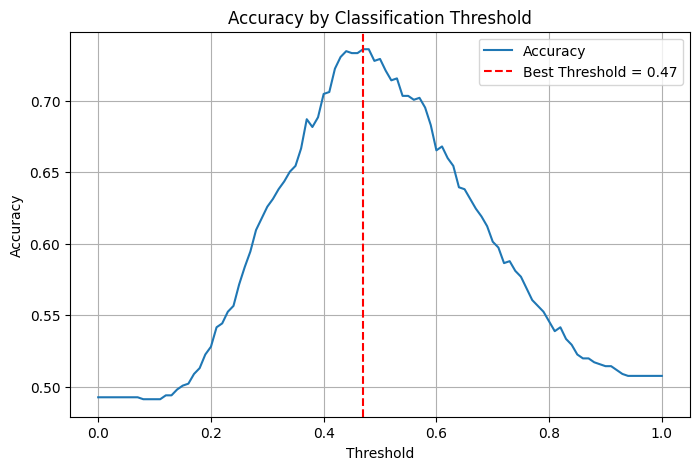

In [63]:
pipeline.fit(X_train, y_train)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

thresholds = np.arange(0, 1.01, 0.01)
accuracies = [accuracy_score(y_test, y_test_proba > t) for t in thresholds]

best_threshold = thresholds[np.argmax(accuracies)]
print(f"Best threshold for Accuracy: {best_threshold:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, label="Accuracy")
plt.axvline(
    best_threshold,
    color="red",
    linestyle="--",
    label=f"Best Threshold = {best_threshold:.2f}",
)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy by Classification Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [64]:
def normalize_text(text):
    return re.sub(r"\s+", " ", text).strip()


def predict_bias_from_article(title, model):
    article_text = fetch_article(title)
    sentences = sent_tokenize(normalize_text(article_text))

    temp_df = pd.DataFrame({"combined_text": sentences})
    temp_df["lexicon_match_count"] = temp_df["combined_text"].apply(
        lambda x: sum(word in bias_words_set for word in str(x).lower().split())
    )

    preds = model.predict(temp_df)
    proba = model.predict_proba(temp_df)[:, 1]
    preds = (proba > best_threshold).astype(int)
    bias_score = proba.mean()

    return {
        "bias_score": round(bias_score, 3),
        "biased_sentences": int(preds.sum()),
        "total_sentences": len(sentences),
        "sentences": sentences,
        "predictions": preds,
        "probabilities": proba,
    }

────────────────────────────────────────────────────────────────────────────

This function checks how biased a Wikipedia article is.

It fetches the article, splits it into sentences, and creates a DataFrame.  
Some default values are added to match what the model was trained on.  
It then uses the model to predict how biased each sentence is, using a custom threshold of `0.33`.  
It returns the bias score (percent of biased sentences), the sentence predictions, and their probabilities.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I ran an analysis to optimize the threshold for accuracy and found the best value to be `0.47`, so that is what the function uses.

I added a `normalize_text` function to trim white space.

I removed the hardcoded features (`bias_word_count`, `outlet`, `topic`, `type`, and `label_opinion`) that contribute nothing to the model and computed the `lexicon_match_count` for each article.

I changed the bias score from percent of biased sentences to the average probability of bias across sentences. It smoothed out the scores and reshuffled the order of topics a bit, but it did not substantively change the results. If we prefer the intuitive appeal of saying the bias score is the percent of biased sentences, we can change it back. 

────────────────────────────────────────────────────────────────────────────

In [65]:
# Rebuilding based on recent best results
vectorizer = TfidfVectorizer(
    max_features=20000, ngram_range=(1, 4), stop_words="english"
)
classifier = LogisticRegression(max_iter=1000, solver="liblinear", C=10.0)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, text_feature),
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(steps=[("preprocessing", preprocessor), ("classifier", classifier)])

X = df_sg2[[text_feature] + numeric_features]
y = df_sg2["label"]
pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=20000,
                                                                  ngram_range=(1,
                                                                               4),
                                                                  stop_words='english'),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['lexicon_match_count'])])),
                ('classifier',
                 LogisticRegression(C=10.0, max_iter=1000,
                                    solver='liblinear'))])

────────────────────────────────────────────────────────────────────────────

This code rebuilds and trains the final machine learning pipeline.

It uses `TfidfVectorizer` to turn text into numbers, looking at up to 3-word phrases and limiting to 20,000 features.  
It one-hot encodes categories like outlet and topic, and standardizes numeric columns.  
All features are combined and passed into a logistic regression model.  
The full pipeline is then trained using the labeled dataset.

────────────────────────────────────────────────────────────────────────────

In [66]:
results = predict_bias_from_article("Donald Trump", pipeline)

print(
    f"Bias Score: {results['bias_score']} ({results['biased_sentences']} of {results['total_sentences']} sentences)"
)

Bias Score: 0.447 (255 of 563 sentences)


────────────────────────────────────────────────────────────────────────────

This runs the bias prediction function on the Wikipedia article for "Donald Trump".

It prints a final score showing that **63 out of 557 sentences** were predicted as biased,  
resulting in a **bias score of 0.113**, or **11.3%** of the article.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

The bias score is now much higher for the "Donald Trump" article:

- **252 out of 563 sentences** were predicted as biased
- **bias score = 0.445**

────────────────────────────────────────────────────────────────────────────

In [67]:
for sent, prob in sorted(
    zip(results["sentences"], results["probabilities"]),
    key=lambda x: x[1],
    reverse=True,
):
    if prob > best_threshold:
        print(f"⚠️ {round(prob, 3)}: {sent}")

⚠️ 0.977: Trump is the central figure of Trumpism, and his faction is dominant within the Republican Party.
⚠️ 0.974: Racist and Islamophobic attitudes are strong indicators of support for Trump.
⚠️ 0.973: Relations between the U.S. and its European allies were strained under Trump.
⚠️ 0.972: He used harsher, more dehumanizing anti-immigrant rhetoric than during his presidency.
⚠️ 0.972: Political practice and rhetoric Beginning with his 2016 campaign, Trump's politics and rhetoric led to the creation of a political movement known as Trumpism.
⚠️ 0.969: Trump has also used anti-communist sentiment in his rhetoric, regularly calling his opponents "communists" and "Marxists".
⚠️ 0.967: External links Archive of Donald Trump's tweets Appearances on C-SPAN Donald Trump at IMDb Donald Trump on the Internet Archive
⚠️ 0.967: Race relations Trump's comments on the 2017 Unite the Right rally, condemning "this egregious display of hatred, bigotry and violence on many sides" and stating that the

────────────────────────────────────────────────────────────────────────────

These are the sentences from the "Donald Trump" Wikipedia article that the model flagged as biased, using a threshold of **0.33**.

Each line shows the **bias probability score** followed by the sentence.  
Most sentences are between **0.33 and 0.45**, which means they aren't obviously biased, but may contain **framing, emotionally charged words, or subtle implications** the model picked up on.

Examples include:
- Highlighting **wealth and privilege** in early life
- Mentioning **bankruptcies** and **legal troubles**
- Using phrases like `"racist or misogynistic"` or `"promoted conspiracy theories"`

This confirms the model can detect **subtle linguistic bias**, even in an article that follows an encyclopedic style.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I changed the threshold to `0.47`, which flagged many more sentences with biase scores ranging between **0.47 and 0.98**, but the general analysis probably still applies. 

I also sorted the sentences by bias to make them easier to evaluate. 

────────────────────────────────────────────────────────────────────────────

## Creating Datasets:

In [68]:
def process_wikipedia_articles(
    titles, model, output_file="../scraped_data/wiki_bias_predictions.csv"
):
    all_data = []

    for title in titles:
        try:
            text = fetch_article(title)
            sentences = sent_tokenize(normalize_text(text))

            temp_df = pd.DataFrame({"combined_text": sentences})
            temp_df["lexicon_match_count"] = temp_df["combined_text"].apply(
                lambda x: sum(word in bias_words_set for word in str(x).lower().split())
            )

            preds = model.predict(temp_df)
            proba = model.predict_proba(temp_df)[:, 1]

            temp_df["bias_prediction"] = preds
            temp_df["bias_probability"] = proba
            temp_df["article_title"] = title
            temp_df["sentence_index"] = temp_df.index

            all_data.append(temp_df)

        except Exception as e:
            print(f"error: {title} — {e}")

    final_df = pd.concat(all_data, ignore_index=True)
    final_df.to_csv(output_file, index=False)
    return final_df

────────────────────────────────────────────────────────────────────────────

This function takes in a list of Wikipedia article titles and runs **bias prediction** on every sentence from every article.

For each title:
- It fetches the article and splits it into sentences.
- A temporary dataset is created with default metadata (like outlet and topic) to match what the model expects.
- The model predicts bias for each sentence and adds the result and the bias probability.
- It adds the article name and sentence index for organization.

All the sentence results from all articles are combined into one dataset and saved as a single CSV file called `wiki_bias_predictions.csv`.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I normalized the text, removed the hardcoded features (`bias_word_count`, `outlet`, `topic`, `type`, and `label_opinion`) that contribute nothing to the model, and computed the `lexicon_match_count` for each article.

I returned the `final_df` to do some EDA. 

────────────────────────────────────────────────────────────────────────────

In [69]:
topics = [
    "Donald Trump",
    "Joe Biden",
    "Kamala Harris",
    "Barack Obama",
    "Ron DeSantis",
    "Bernie Sanders",
    "Tea Party movement",
    "QAnon",
    "Pro-life",
    "Pro-choice",
    "Abortion in the United States",
    "Gun control",
    "Second Amendment",
    "Immigration to the United States",
    "Border wall",
    "Transgender rights",
    "LGBT adoption",
    "Same-sex marriage",
    "Gender identity",
    "Critical race theory",
    "Affirmative action",
    "Fox News",
    "MSNBC",
    "CNN",
    "Breitbart News",
    "The New York Times",
    "Israeli-Palestinian conflict",
    "Hamas",
    "Ukraine war",
    "Russian invasion of Ukraine",
    "NATO",
    "Taliban",
    "Evangelicalism",
    "Islamophobia",
    "Christian nationalism",
    "Religious freedom in the United States",
    "Climate change",
    "COVID-19 pandemic",
    "Vaccine hesitancy",
    "Misinformation",
    "Flat Earth",
    "Creationism",
    "Police brutality",
    "Black Lives Matter",
    "Stop and frisk",
    "War on drugs",
    "Norway",
    "Baseball",
    "Apple pie",
    "Moon",
    "Nintendo",
    "Water cycle",
    "Mount Everest",
    "Planet Earth",
    "Pencil",
    "Library",
    "Train station",
    "Paper",
    "Clock",
    "Miocene",
    "Milan",
    "Pangea",
    "Jogging",
    "Crustacean",
    "Sand dune",
    "Origami",
    "Bicycle",
    "Caterpillar",
    "Seahorse",
    "Quartz",
    "Umbrella",
    "Refrigerator",
    "Metronome",
    "Snowman",
    "Fire extinguisher",
    "Symbiosis",
    "Euclid",
    "Photosynthesis",
    "Guitar",
]

────────────────────────────────────────────────────────────────────────────

We chose a large number of topics to ensure that the final dataset would be rich, diverse, and well-populated.

Not every Wikipedia article always works — sometimes a page doesn’t exist, fails to load, or doesn’t contain usable sentence structure.  
By including a wide mix of political, social, scientific, and controversial topics, we increase the chances that most will work.  
This guarantees that even if some articles are skipped or throw errors, we still end up with a **good-sized, well-balanced dataset** for bias analysis.

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

I added 33 seemingly boring topics to serve as controls, and I dropped a few articles with only 1 sentence. You can see below that they are actually pretty well distributed among the bias scores. We might want to look at a few examples of each at a sentence level during the presentation to talk about why, for example, Islamophobia and Caterpillar have such high bias scores while Gun Control and NATO are so low. We could also spend more time choosing interesting examples, but I think this is a decent start. 

────────────────────────────────────────────────────────────────────────────

In [70]:
wiki_sentence_dataset = process_wikipedia_articles(topics, pipeline)

────────────────────────────────────────────────────────────────────────────

This line runs the full bias detection process on all the topics in the `topics` list using the trained model `pipeline`.

It goes through each article, predicts bias sentence-by-sentence, and saves the results into a single CSV file.  
By the end, you'll have one dataset with bias predictions across all the selected Wikipedia topics, ready for further analysis or visualization.

────────────────────────────────────────────────────────────────────────────

In [71]:
wiki_sentence_dataset

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
0,"Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States.",0,1,0.764118,Donald Trump,0
1,"A member of the Republican Party, he served as the 45th president from 2017 to 2021.",0,1,0.648743,Donald Trump,1
2,"Born into a wealthy family in the New York City borough of Queens, Trump graduated from the University of Pennsylvania in 1968 with a bachelor's degree in economics.",0,1,0.699748,Donald Trump,2
3,"He became the president of his family's real estate business in 1971, renamed it the Trump Organization, and began acquiring and building skyscrapers, hotels, casinos, and golf courses.",0,1,0.687404,Donald Trump,3
4,"He launched side ventures, many licensing the Trump name, and filed for six business bankruptcies in the 1990s and 2000s.",0,1,0.656600,Donald Trump,4
...,...,...,...,...,...,...
27218,"""Guitar"".",0,0,0.497191,Guitar,457
27219,Oxford Music Online.,0,1,0.611567,Guitar,458
27220,Oxford University Press.,0,0,0.168916,Guitar,459
27221,Retrieved 20 May 2016.,0,0,0.099191,Guitar,460


In [72]:
def summarize_articles(titles, model):
    summaries = []

    for title in titles:
        try:
            result = predict_bias_from_article(title, model)
            summaries.append(
                {
                    "title": title,
                    "bias_score": result["bias_score"],
                    "biased_sentences": result["biased_sentences"],
                    "total_sentences": result["total_sentences"],
                }
            )
        except Exception as e:
            print(f"error: {title} — {e}")

    summaries_df = pd.DataFrame(summaries)
    summaries_df["percent_biased"] = (
        summaries_df["biased_sentences"] / summaries_df["total_sentences"]
    ).round(3)

    return summaries_df

────────────────────────────────────────────────────────────────────────────

**Randy's Update**

This function takes in a list of Wikipedia article titles and runs **bias prediction** on every article.

For each title:
- It fetches the article and produces a bias score by aggregating sentence-level bias predictions.
- It returns a dataset with article titles, bias scores, the number of biased sentences, and the number of total sentences, and the percent of sentences biased.

────────────────────────────────────────────────────────────────────────────

In [73]:
wiki_article_dataset = summarize_articles(topics, pipeline).sort_values(
    by="bias_score", ascending=False
)

wiki_article_dataset

,title,bias_score,biased_sentences,total_sentences,percent_biased
18,Gender identity,0.551,146,223,0.655
24,Breitbart News,0.539,146,256,0.570
21,Fox News,0.534,363,604,0.601
33,Islamophobia,0.530,195,342,0.570
67,Caterpillar,0.522,84,137,0.613
...,...,...,...,...,...
4,Ron DeSantis,0.328,78,302,0.258
43,Black Lives Matter,0.320,169,665,0.254
30,NATO,0.319,47,245,0.192
37,COVID-19 pandemic,0.306,139,619,0.225


# Exploring the Sentence and Article Datasets

### How long are the texts in the sentence dateset?

In [74]:
wiki_sentence_wordcount = (
    wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len()
)
wiki_sentence_wordcount.describe()

count    27223.000000
mean        23.085185
std         14.328725
min          1.000000
25%         14.000000
50%         21.000000
75%         29.000000
max        463.000000
Name: combined_text, dtype: float64

The longest sentence in the dataset contains 463 words, while the shortest contains just 1 word. The median word count is 21, and the standard deviation is 14.32. That includes some very long sentences, but on the whole, these texts are similar in length to the training set. 

In [75]:
mean = wiki_sentence_wordcount.mean()
std = wiki_sentence_wordcount.std()
wiki_sentence_wordcount_filtered = wiki_sentence_wordcount[
    wiki_sentence_wordcount <= mean + 3 * std
]
outliers = len(wiki_sentence_wordcount) - len(wiki_sentence_wordcount_filtered)

print(
    f"Word Count Outliers : {outliers} ({100*outliers/len(wiki_sentence_wordcount):0.2f}%)"
)

Word Count Outliers : 258 (0.95%)


There are 258 sentences greater than 3 standard deviations above the mean in length, representing less than 1% of the sentence dataset. 

To visualize this data (after removing outliers to make the data legible):

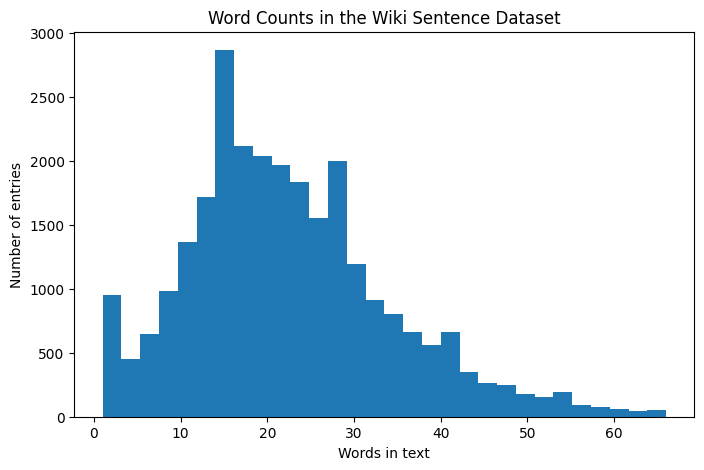

In [76]:
wiki_sentence_wordcount_filtered.plot(
    title="Word Counts in the Wiki Sentence Dataset",
    kind="hist",
    bins=30,
    figsize=[8, 5],
    xlabel="Words in text",
    ylabel="Number of entries",
)

plt.show()

We can see something loosely resembling a right-skewed normal distribution here, ranging from 1 word to more than 60. 

### How many words match the bias word lexicon in the sentence dataset?

In [77]:
wiki_sentence_dataset["lexicon_match_count"].value_counts()

lexicon_match_count
0    25742
1     1229
2      206
3       35
5        4
4        4
7        3
Name: count, dtype: int64

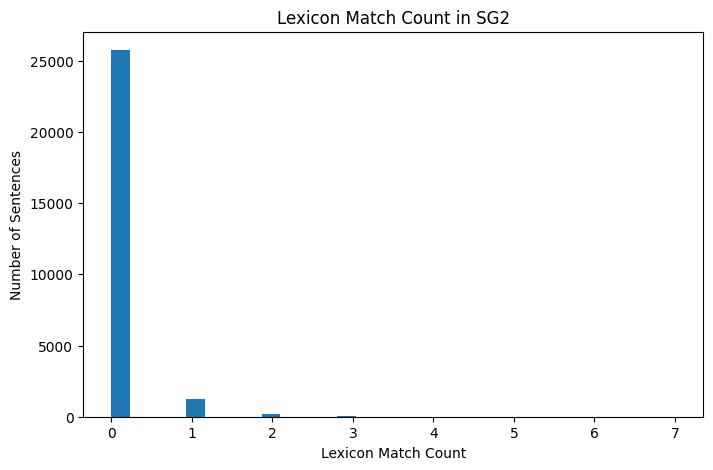

In [78]:
wiki_sentence_dataset["lexicon_match_count"].plot(
    title="Lexicon Match Count in SG2",
    kind="hist",
    bins=30,
    figsize=[8, 5],
    xlabel="Lexicon Match Count",
    ylabel="Number of Sentences",
)

plt.show()

The vast majority of sentences in the sentence dataset (95%) have no matching words from the bias word lexicon included with the BABE source, even more than in the SG2 dataset. A small number of sentences have 1 or 2 matching words (5%), and a negligible number (46 sentences) have between 3 and 7 matching words.

### How biased are the sentences?

In [79]:
wiki_sentence_dataset["bias_prediction"].value_counts()

bias_prediction
0    18349
1     8874
Name: count, dtype: int64

In [80]:
wiki_sentence_dataset["bias_probability"].describe()

count    27223.000000
mean         0.410048
std          0.215499
min          0.000141
25%          0.235190
50%          0.393478
75%          0.560026
max          0.999352
Name: bias_probability, dtype: float64

About 1/3 (33%) of the sentences are deemed biased by the model. Bias scores range between 0 and 1, with a mean of 0.39 and a standard deviation of 0.22. Most sentences have moderate bias scores between 0.23 and 0.56. 

### How long are the texts in the article dateset?

In [81]:
wiki_article_dataset["total_sentences"].describe()

count     79.000000
mean     344.594937
std      197.115775
min       49.000000
25%      184.000000
50%      310.000000
75%      519.500000
max      753.000000
Name: total_sentences, dtype: float64

The longest article in the dataset contains 753 sentences, while the shortest contains 49 sentences. The median sentence count is 310, and the standard deviation is 197.

### How biased are the articles?

In [82]:
display(wiki_article_dataset["bias_score"].describe())
wiki_article_dataset["percent_biased"].describe()

count    79.000000
mean      0.419443
std       0.059292
min       0.284000
25%       0.378000
50%       0.417000
75%       0.454000
max       0.551000
Name: bias_score, dtype: float64

count    79.000000
mean      0.407886
std       0.113623
min       0.183000
25%       0.321500
50%       0.395000
75%       0.493000
max       0.655000
Name: percent_biased, dtype: float64

The bias scores for all 79 articles range from 0.28 to 0.55, with a median of 0.42 and a standard deviation of 0.06. Most of the bias scores are moderate without any particularly extreme values. The percentage of sentences that are biased per article ranges from 19% to 65%, with a median of 40% and a standard deviation of 11%. 

The top and bottom 25 article titles according to bias score are the following:

In [83]:
display(wiki_article_dataset.head(25))
wiki_article_dataset.tail(25)

,title,bias_score,biased_sentences,total_sentences,percent_biased
18,Gender identity,0.551,146,223,0.655
24,Breitbart News,0.539,146,256,0.570
21,Fox News,0.534,363,604,0.601
33,Islamophobia,0.530,195,342,0.570
67,Caterpillar,0.522,84,137,0.613
19,Critical race theory,0.512,157,278,0.565
76,Euclid,0.508,74,131,0.565
25,The New York Times,0.508,227,412,0.551
77,Photosynthesis,0.506,180,310,0.581
75,Symbiosis,0.504,78,143,0.545


,title,bias_score,biased_sentences,total_sentences,percent_biased
55,Library,0.384,70,214,0.327
38,Vaccine hesitancy,0.383,206,621,0.332
5,Bernie Sanders,0.382,240,647,0.371
59,Miocene,0.382,54,183,0.295
60,Milan,0.381,196,557,0.352
3,Barack Obama,0.375,168,518,0.324
52,Mount Everest,0.375,239,753,0.317
45,War on drugs,0.374,197,617,0.319
42,Police brutality,0.372,45,136,0.331
47,Baseball,0.371,133,417,0.319


It is instructive to look at a few examples in more detail. Let's explore the most and least biased articles.

In [84]:
test_title = "Gender identity"
results = predict_bias_from_article(test_title, pipeline)

test_score = wiki_article_dataset[wiki_article_dataset["title"] == test_title][
    "bias_score"
].item()
test_percent = (
    100
    * wiki_article_dataset[wiki_article_dataset["title"] == test_title][
        "percent_biased"
    ].item()
)
print(
    f"Bias Score for the {test_title} article: {test_score} ({int(test_percent)}% of sentences biased)"
)

print("Top 10 most biased sentences:")
for sent, prob in sorted(
    zip(results["sentences"], results["probabilities"]),
    key=lambda x: x[1],
    reverse=True,
)[:10]:
    print(f"⚠️ {round(prob, 3)}: {sent}")

Bias Score for the Gender identity article: 0.551 (65% of sentences biased)
Top 10 most biased sentences:
⚠️ 0.948: As a baby, Reimer went through a faulty circumcision, losing his male genitalia.
⚠️ 0.94: Gender identity is the personal sense of one's own gender.
⚠️ 0.932: Gender identity can correlate with a person's assigned sex or can differ from it.
⚠️ 0.931: The females that were born had genitalia that looked like male genitalia.
⚠️ 0.924: The social learning theory posits that children furthermore develop their gender identity through observing and imitating gender-linked behaviors, and then being rewarded or punished for behaving that way, thus being shaped by the people surrounding them through trying to imitate and follow them.
⚠️ 0.918: A type of anti-gender rhetoric where people are ascribed a gender that does not match their gender identity is called misgendering.
⚠️ 0.916: Constructivism of this type is not necessarily incompatible with the existence of an innate gender 

In [85]:
test_title = "Russian invasion of Ukraine"
results = predict_bias_from_article(test_title, pipeline)

test_score = wiki_article_dataset[wiki_article_dataset["title"] == test_title][
    "bias_score"
].item()
test_percent = (
    100
    * wiki_article_dataset[wiki_article_dataset["title"] == test_title][
        "percent_biased"
    ].item()
)
print(
    f"Bias Score for the {test_title} article: {test_score} ({int(test_percent)}% of sentences biased)"
)

print("Top 10 most biased sentences:")
for sent, prob in sorted(
    zip(results["sentences"], results["probabilities"]),
    key=lambda x: x[1],
    reverse=True,
)[:10]:
    print(f"⚠️ {round(prob, 3)}: {sent}")

Bias Score for the Russian invasion of Ukraine article: 0.284 (18% of sentences biased)
Top 10 most biased sentences:
⚠️ 0.943: Such missiles are more effective in evading conventional Ukrainian anti-missile defences that had previously proved useful against Russia's conventional, non-hypersonic missile systems.
⚠️ 0.845: Satellite imagery showed at least eight aircraft damaged or destroyed.
⚠️ 0.843: Sanctions forced Russia to reorient its oil exports to non-sanctioning countries such as India, rely more on LNG (which was not subject to European Union sanctions), and shift its coal exports from Europe to Asia.
⚠️ 0.841: Most European countries cancelled nuclear cooperation with Russia.
⚠️ 0.807: Most of us know this and it's why we fight so fearlessly."
⚠️ 0.804: The invasion had an impact on Ukraine's nuclear power plants.
⚠️ 0.804: Britain has accepted 146,379 refugees, as well as extending the ability to remain in the UK for three years with broadly similar entitlements as the EU, 

For the most biased article (Gender identity), the top ten most biased sentences all have scores greater than 0.9. They include sensitive words that might contribute to the high bias score, such as "faulty", "circumcision", "genitalia", "sex", "punished" "rhetoric", "misgendering", and "deadnaming." 

The least biased article (Russian invasion of Ukraine) has only one sentence scoring above 0.9, and the top ten most biased sentences have scores as low as 0.79. That explains the lower bias score for the article. These sentences also include potentially sensitive words that might be flagged as biased, such as "missile", "evading", "sanction", "destroyed", "cancelled", "nuclear", "fearlessly", and "looting". 

The number and nature of sensitive words and phrases reflecting subtle linguistic bias determine the bias scores of the respective articles. Examining a few examples shows that all articles have some such linguistic features, but some have more than others. The training data from BABE is specifically devoted to news articles in the media, so our model concentrates on language considered biased in that context. Since Wikipedia articles are somewhat different in tone and style, what is considered biased in the context of news might not always align with more encyclopedic language. For example, discussion of sex and genitalia might be considered inappropriate in media coverage, despite being presented factually in an encyclopedic context. Similarly, unbiased news articles about war might make the model less sensitive to words about violence and weaponry. 

Overall, these bias scores are a reasonable place to start for evaluating bias in Wikipedia articles, even if there might be some misalignment between news stories and encyclopedia entries. 

Future work on this topic should consider several enhancements:
- Use a dataset specifically devoted to Wikipedia articles, such as the WikiBias Multi-Span Bias Corpus or the Wikipedia Neutrality Corpus, to ensure more directly relevant training examples.
- Leverage more advanced word embeddings, such as BERT or RoBERTa, to capture richer contextual and semantic information.
- Explore deeper neural architectures, including multi-layer models built on top of pre-trained transformers, to better model linguistic nuance.

These strategies would provide more targeted data, harness more sophisticated language representations, and employ more powerful models — all of which could improve performance in identifying subtle bias in Wikipedia articles. Given the time constraints of this project, we opted for a simpler, more accessible approach. 

**Ken's Update**

In addition to some exploratory analysis of our main data, I wanted to compare the way using different training data might affect the results. `SG1` and `MBIC` contain texts that are a subset of `SG2`'s texts, but they used different techniques for labeling bias: `SG1` was labeled by a panel of experts, where `MBIC`'s labels were crowdsourced.


# Comparing SG1 to MBIC

As a bonus objective of sorts, let's compare SG1 to MBIC. Both of these data sets contain 1700 texts, which are a subset of the texts in SG2. However, the key difference is that they were rated for bias by different groups: SG1 was rated by a panel of experts, while MBIC used crowdsourcing.

If we train two models identically, with the sole difference being whether SG1 or MBIC's labels were used, **which one finds more bias in the Wikipedia test set?**

In [86]:
df_sg1 = pd.read_csv(os.path.join(dataset_path, "final_labels_SG1.csv"), sep=";")
df_mbic = pd.read_csv(os.path.join(dataset_path, "final_labels_MBIC.csv"), sep=";")

In [87]:
df_sg1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           1700 non-null   object
 1   news_link      1672 non-null   object
 2   outlet         1700 non-null   object
 3   topic          1700 non-null   object
 4   type           1700 non-null   object
 5   label_bias     1700 non-null   object
 6   label_opinion  1700 non-null   object
 7   biased_words   1700 non-null   object
dtypes: object(8)
memory usage: 106.4+ KB


In [88]:
# fixing two typographical errors present in MBIC's data--discovered these while working in another notebook

df_mbic.loc[1544, "text"] = df_sg1.loc[423, "text"]
df_mbic.loc[923, "text"] = df_sg1.loc[453, "text"]
df_mbic["text"].isin(df_sg1["text"]).value_counts()

text
True    1700
Name: count, dtype: int64

While I discovered SG1 is also missing some `news_link`s that are present in MBIC, I'll be dropping that data anyway since it's not going to be relevant to the test data, so there's little point in fixing it.



In [89]:
wiki_sentence_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27223 entries, 0 to 27222
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   combined_text        27223 non-null  object 
 1   lexicon_match_count  27223 non-null  int64  
 2   bias_prediction      27223 non-null  int64  
 3   bias_probability     27223 non-null  float64
 4   article_title        27223 non-null  object 
 5   sentence_index       27223 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.2+ MB


In [90]:
wiki_sentence_dataset.head(1)

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
0,"Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States.",0,1,0.764118,Donald Trump,0


The `wiki_sentence_dataset` from earlier has a `combined_text`, which is equivalent to `text` from the SG1 and MBIC sets. Let's take a closer look at it:

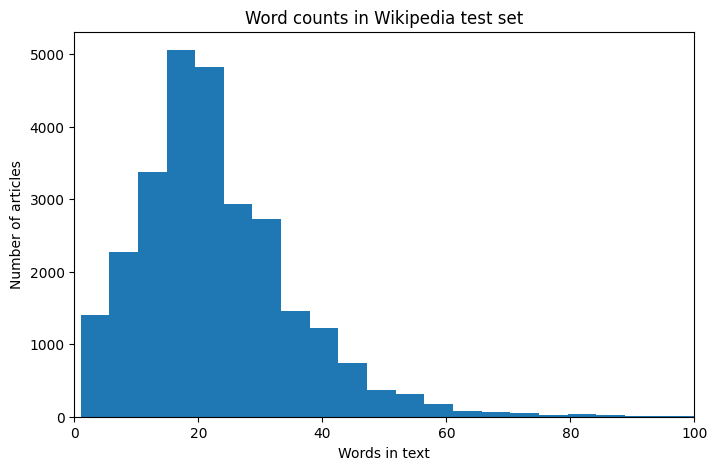

In [91]:
wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len().plot(
    title="Word counts in Wikipedia test set",
    kind="hist",
    bins=100,
    figsize=[8, 5],
    xlabel="Words in text",
    ylabel="Number of articles",
    xlim=[0, 100],
)

plt.show()

A few interesting things: the test set contained a small number of 100+ outliers, necessitating using `xlim` for the chart. It's also just a far bigger test set than the training sets, reflecting over 27000 sentences pulled from scores of articles. 

Moreover:

In [92]:
wiki_sentence_dataset[
    wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len() <= 5
]

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
73,He remained chairman until 2009.,0,0,0.450528,Donald Trump,73
366,Trump pleaded not guilty.,0,1,0.637303,Donald Trump,366
479,He has denied the allegations.,0,0,0.439634,Donald Trump,479
481,You can do anything.,0,0,0.497191,Donald Trump,481
482,...,0,0,0.497191,Donald Trump,482
...,...,...,...,...,...,...
27217,"Turnbull, Harvey; et al.",0,1,0.514770,Guitar,456
27218,"""Guitar"".",0,0,0.497191,Guitar,457
27219,Oxford Music Online.,0,1,0.611567,Guitar,458
27220,Oxford University Press.,0,0,0.168916,Guitar,459


The Wikipedia data contains a lot of short sentences reflecting things like sources, sentences cut off midway through due to abbreviations, and some actual coherent sentences as well, such as "Trump pleaded not guilty."

SG1, MBIC, and SG2 contain extremely few short thoughts like these.

# Exploring SG1 and MBIC

### Did SG1 or MBIC find more biased sentences?

In [93]:
df_sg1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           1700 non-null   object
 1   news_link      1672 non-null   object
 2   outlet         1700 non-null   object
 3   topic          1700 non-null   object
 4   type           1700 non-null   object
 5   label_bias     1700 non-null   object
 6   label_opinion  1700 non-null   object
 7   biased_words   1700 non-null   object
dtypes: object(8)
memory usage: 106.4+ KB


In [94]:
# df_mbic contains extra columns not present in df_sg1; we'll drop those to make the comparison more 1:1
droppables = ["group_id", "num_sent", "article"]
df_mbic = df_mbic.drop(droppables, axis=1)
df_mbic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           1700 non-null   object
 1   news_link      1681 non-null   object
 2   outlet         1700 non-null   object
 3   topic          1700 non-null   object
 4   type           1700 non-null   object
 5   label_bias     1700 non-null   object
 6   label_opinion  1700 non-null   object
 7   biased_words   1700 non-null   object
dtypes: object(8)
memory usage: 106.4+ KB


In [95]:
label_biases = pd.concat(
    [df_mbic["label_bias"].value_counts(), df_sg1["label_bias"].value_counts()], axis=1
)
label_biases.columns = ["MBIC", "SG1"]
label_biases.head()

,MBIC,SG1
label_bias,,
Biased,1018,746
Non-biased,533,800
No agreement,149,154


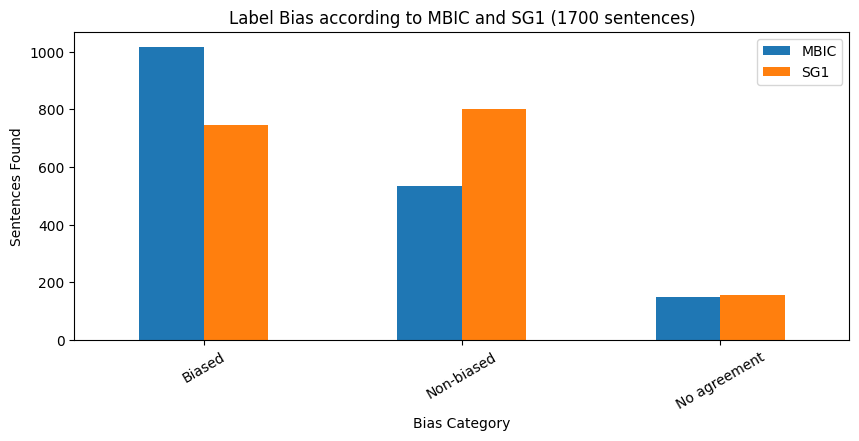

In [96]:
label_biases.plot(
    title="Label Bias according to MBIC and SG1 (1700 sentences)",
    kind="bar",
    rot=30,
    xlabel="Bias Category",
    ylabel="Sentences Found",
    figsize=[10, 4],
)

plt.show()

MBIC, which crowdsourced labeling, was more sensitive to bias than SG1. 

### How many texts did SG1 and MBIC disagree on?

We can concatenate the `label_bias` from one training set to the other. We will remove it later for training, of course.

In [97]:
df_mbic["sg1_label_bias"] = df_sg1["label_bias"]
label_mismatches = df_mbic.loc[df_mbic["label_bias"] != df_mbic["sg1_label_bias"]]
label_mismatches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1001 entries, 1 to 1699
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            1001 non-null   object
 1   news_link       990 non-null    object
 2   outlet          1001 non-null   object
 3   topic           1001 non-null   object
 4   type            1001 non-null   object
 5   label_bias      1001 non-null   object
 6   label_opinion   1001 non-null   object
 7   biased_words    1001 non-null   object
 8   sg1_label_bias  1001 non-null   object
dtypes: object(9)
memory usage: 78.2+ KB


1001 of the 1700 labels caused disagreement! We can also find the ones that do match:

In [98]:
label_matches = df_mbic.loc[df_mbic["label_bias"] == df_mbic["sg1_label_bias"]]
label_matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 699 entries, 0 to 1697
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            699 non-null    object
 1   news_link       691 non-null    object
 2   outlet          699 non-null    object
 3   topic           699 non-null    object
 4   type            699 non-null    object
 5   label_bias      699 non-null    object
 6   label_opinion   699 non-null    object
 7   biased_words    699 non-null    object
 8   sg1_label_bias  699 non-null    object
dtypes: object(9)
memory usage: 54.6+ KB


We can then compare these two subsets of data. For example:

### Were some news outlets more likely to cause diagreement between SG1 and MBIC?

We can calculate this by dividing the `value_counts` of `outlet` in the mismatch dataframe to either MBIC or SG1's equivalent (the two datasets are identical on that column).

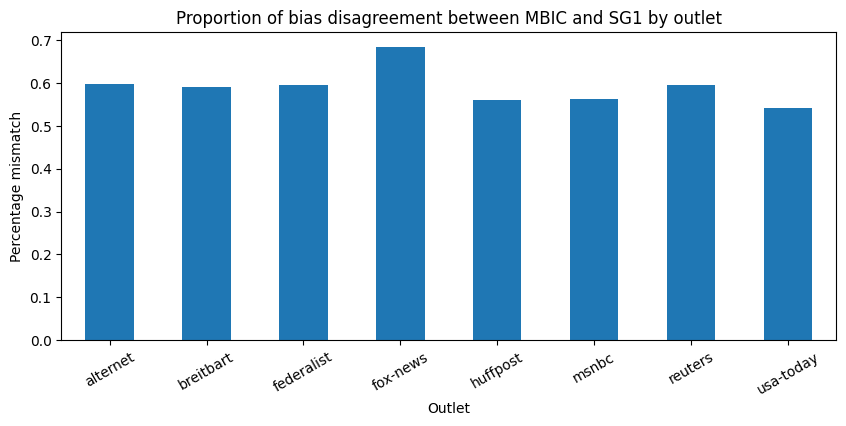

outlet
alternet      0.597633
breitbart     0.591512
federalist    0.596059
fox-news      0.684685
huffpost      0.561404
msnbc         0.561983
reuters       0.594937
usa-today     0.541401
Name: count, dtype: float64

In [99]:
disagreements = label_mismatches["outlet"].value_counts() / (
    df_sg1["outlet"].value_counts()
)
disagreements.plot(
    title="Proportion of bias disagreement between MBIC and SG1 by outlet",
    kind="bar",
    xlabel="Outlet",
    rot=30,
    ylabel="Percentage mismatch",
    figsize=[10, 4],
)

plt.show()
disagreements

We can see that Fox News was somewhat more likely to cause disagreement between SG1 and MBIC's rating systems, but all of the rest were within six percentage points of each other.

Fox is relatively underrepresented in this data, so it could just be explained by random variance:

In [100]:
df_sg1["outlet"].value_counts()

outlet
breitbart     377
alternet      338
msnbc         242
federalist    203
reuters       158
usa-today     157
huffpost      114
fox-news      111
Name: count, dtype: int64

## Do SG1 and MBIC differ in what kinds of opinions are biased?

We can compare the `type` column, which indicates the leaning of the outlet the text came from, and then also look at the `label_bias` column to see whether the entry was considered biased.

In [101]:
sg1_leanings = df_sg1.groupby(["type", "label_bias"]).count()
sg1_leanings

text  news_link  outlet  topic  label_opinion  \
type   label_bias                                                    
center Biased          38         38      38     38             38   
       No agreement    16         16      16     16             16   
       Non-biased     261        254     261    261            261   
left   Biased         331        327     331    331            331   
       No agreement    67         67      67     67             67   
       Non-biased     296        295     296    296            296   
right  Biased         377        367     377    377            377   
       No agreement    71         69      71     71             71   
       Non-biased     243        239     243    243            243   

                     biased_words  
type   label_bias                  
center Biased                  38  
       No agreement            16  
       Non-biased             261  
left   Biased                 331  
       No agreement            67  
       Non-biased             296  
right  Biased                 377  
       No agreement            71  
       Non-biased             243

In [102]:
mbic_leanings = df_mbic.groupby(["type", "label_bias"]).count()
mbic_leanings.loc["center"].loc["Biased"]

text              88
news_link         88
outlet            88
topic             88
label_opinion     88
biased_words      88
sg1_label_bias    88
Name: Biased, dtype: int64

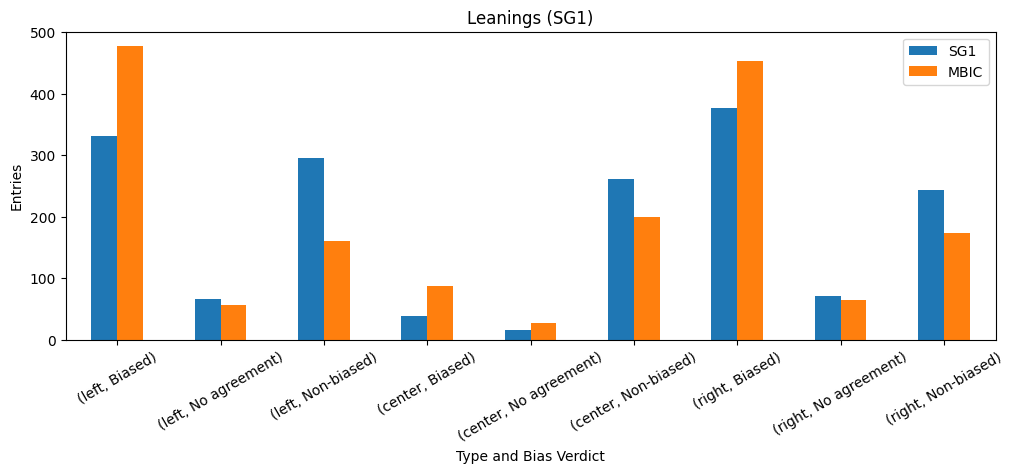

In [103]:
leanings = pd.concat([sg1_leanings["outlet"], mbic_leanings["outlet"]], axis=1)
leanings.columns = ["SG1", "MBIC"]
leanings = leanings.loc[["left", "center", "right"]]
leanings.plot(
    title="Leanings (SG1)",
    kind="bar",
    rot=30,
    figsize=[12, 4],
    xlabel="Type and Bias Verdict",
    ylabel="Entries",
)

plt.show()

This chart shows a few interesting traits:

- MBIC consistently found more biased results than SG1 did and fewer non-biased results, across all three ideological categories
- The difference is closer for right-leaning sources
    - MBIC found slightly more left-leaning biased texts than right-leaning ones; SG1 found slightly more right-leaning biased texts than left-leaning ones
- Both sets of labelers generally thought center-leaning sources were usually not biased, while the other two ideological categories were usually biased
- Among "No agreement" texts (where the labelers within each group couldn't decide whether a text was biased), SG1 and MBIC both had disagreements only occasionally
    - This means that the raters from both groups usually thought it was pretty clear whether a text was biased or not

# Comparing SG1 and MBIC as training data

We'll use two logistic regressions, one trained on MBIC's data and one on SG1's data, with their respective `label_bias` columns as targets. We'll then test the models against some scraped Wikipedia pages to see how similar or different the results are. Given the above, **my hypothesis is that MBIC will find more bias in Wikipedia than SG1 will**, but we'll see!

In order to get the models ready for training, we have to do some preprocessing:

In [104]:
# removing the extra column we added earlier
df_mbic = df_mbic.drop("sg1_label_bias", axis=1)
df_mbic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           1700 non-null   object
 1   news_link      1681 non-null   object
 2   outlet         1700 non-null   object
 3   topic          1700 non-null   object
 4   type           1700 non-null   object
 5   label_bias     1700 non-null   object
 6   label_opinion  1700 non-null   object
 7   biased_words   1700 non-null   object
dtypes: object(8)
memory usage: 106.4+ KB


In [105]:
# copied from what we did to SG2 earlier; removing 'No agreement' texts, and encoding bias labels
df_sg1 = df_sg1[df_sg1["label_bias"] != "No agreement"]
df_sg1["label"] = df_sg1["label_bias"].map({"Biased": 1, "Non-biased": 0})
df_sg1.drop(columns="label_bias", inplace=True)

df_mbic = df_mbic[df_mbic["label_bias"] != "No agreement"]
df_mbic["label"] = df_mbic["label_bias"].map({"Biased": 1, "Non-biased": 0})
df_mbic.drop(columns="label_bias", inplace=True)

In [106]:
# creating 'lexicon_match_count

df_sg1["lexicon_match_count"] = df_sg1["text"].apply(
    lambda x: sum(word in bias_words_set for word in str(x).lower().split())
)

df_mbic["lexicon_match_count"] = df_mbic["text"].apply(
    lambda x: sum(word in bias_words_set for word in str(x).lower().split())
)

In [107]:
# adding headlines

df_sg1 = df_sg1.merge(
    headline_full[["url", "title"]], left_on="news_link", right_on="url", how="left"
)

df_sg1["combined_text"] = df_sg1.apply(
    lambda row: (
        f"{row['title']}. {row['text']}" if pd.notnull(row["title"]) else row["text"]
    ),
    axis=1,
)

# df_sg1.drop(columns=['url', 'title'], inplace=True)

df_mbic = df_mbic.merge(
    headline_full[["url", "title"]], left_on="news_link", right_on="url", how="left"
)

df_mbic["combined_text"] = df_mbic.apply(
    lambda row: (
        f"{row['title']}. {row['text']}" if pd.notnull(row["title"]) else row["text"]
    ),
    axis=1,
)

In [108]:
# adding 'combined_text'

df_sg1["combined_text"] = df_sg1.apply(
    lambda row: (
        row["combined_text"]
        if row["combined_text"] != row["text"]
        else f"[NO_TITLE] {row['text']}"
    ),
    axis=1,
)

df_mbic["combined_text"] = df_mbic.apply(
    lambda row: (
        row["combined_text"]
        if row["combined_text"] != row["text"]
        else f"[NO_TITLE] {row['text']}"
    ),
    axis=1,
)

In [109]:
df_sg1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 1546 non-null   object
 1   news_link            1520 non-null   object
 2   outlet               1546 non-null   object
 3   topic                1546 non-null   object
 4   type                 1546 non-null   object
 5   label_opinion        1546 non-null   object
 6   biased_words         1546 non-null   object
 7   label                1546 non-null   int64 
 8   lexicon_match_count  1546 non-null   int64 
 9   url                  119 non-null    object
 10  title                119 non-null    object
 11  combined_text        1546 non-null   object
dtypes: int64(2), object(10)
memory usage: 145.1+ KB


To match what we did with SG2, we'll use `combined_text` as our feature and `label` as our target. SG2 hit a ROC-AUC of 0.804 with these parameters, for reference.

In [110]:
# duplicating SG2 pipeline for SG1

classifier_SG1 = LogisticRegression(
    max_iter=1000, penalty="l2", C=1.0, solver="liblinear"
)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, text_feature),
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline_sg1 = Pipeline(
    steps=[("preprocessing", preprocessor), ("classifier", classifier_SG1)]
)

X = df_sg1[[text_feature] + numeric_features]
y = df_sg1["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

pipeline_sg1.fit(X_train, y_train)
y_pred = pipeline_sg1.predict(X_test)
y_proba = pipeline_sg1.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("SG1 ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       240
           1       0.73      0.55      0.63       224

    accuracy                           0.69       464
   macro avg       0.69      0.68      0.68       464
weighted avg       0.69      0.69      0.68       464

SG1 ROC-AUC: 0.7488095238095238


In [111]:
# duplicating SG2 pipeline for MBIC

classifier_MBIC = LogisticRegression(
    max_iter=1000, penalty="l2", C=1.0, solver="liblinear"
)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, text_feature),
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline_mbic = Pipeline(
    steps=[("preprocessing", preprocessor), ("classifier", classifier_MBIC)]
)

X = df_mbic[[text_feature] + numeric_features]
y = df_mbic["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

pipeline_mbic.fit(X_train, y_train)
y_pred = pipeline_mbic.predict(X_test)
y_proba = pipeline_mbic.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("MBIC ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.66      0.14      0.24       160
           1       0.68      0.96      0.80       306

    accuracy                           0.68       466
   macro avg       0.67      0.55      0.52       466
weighted avg       0.67      0.68      0.60       466

MBIC ROC-AUC: 0.7268382352941176


With this validation technique, SG2 achieved ROC-AUC of about 0.76, while MBIC fared slightly worse at 0.73. Neither were able to match SG2, but as there's less training data, that's not too surprising. This could also indicate SG2 ratings were less noisy than SG1 or MBIC.



In [112]:
# write CSV file with results
sg1_wiki_sentence_dataset = process_wikipedia_articles(
    topics, pipeline_sg1, output_file="../scraped_data/sg1_wiki_bias_predictions.csv"
)

In [113]:
mbic_wiki_sentence_dataset = process_wikipedia_articles(
    topics, pipeline_mbic, output_file="../scraped_data/mbic_wiki_bias_predictions.csv"
)

In [114]:
sg1_wiki_sentence_dataset.head(2)

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
0,"Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States.",0,1,0.622274,Donald Trump,0
1,"A member of the Republican Party, he served as the 45th president from 2017 to 2021.",0,0,0.451384,Donald Trump,1


In [115]:
mbic_wiki_sentence_dataset.head(2)

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
0,"Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States.",0,1,0.635818,Donald Trump,0
1,"A member of the Republican Party, he served as the 45th president from 2017 to 2021.",0,1,0.622908,Donald Trump,1


We now have two sets of test results, `sg1_wiki_sentence_dataset` and `mbic_wiki_sentence_dataset`, which reflect what happened when we asked our SG1 and MBIC models to predict bias on the Wikipedia articles. `bias_prediction` is a binary yes-no prediction of whether a sentence was biased, while `bias_probability` reflects the certainty that the model thought the sentence might be biased.

### How sensitive was each model to bias?

The models both assign `bias_probability` in a range that, in theory, runs from 0-1. In practice, they'll find a more narrow range.

In [116]:
sg1_wiki_sentence_dataset["bias_probability"].describe()

count    27223.000000
mean         0.434926
std          0.069160
min          0.125332
25%          0.394637
50%          0.426860
75%          0.458317
max          0.986921
Name: bias_probability, dtype: float64

In [117]:
mbic_wiki_sentence_dataset["bias_probability"].describe()

count    27223.000000
mean         0.605434
std          0.076758
min          0.196268
25%          0.563751
50%          0.598739
75%          0.628972
max          0.999795
Name: bias_probability, dtype: float64

SG1's minimum bias probability was about 13% to MBIC's 20%, the median was 43% to 59%, and the maximums were 98.7% to 99.98%, meaning both models made heavy use of the top range. Notably the 75th percentile sentence for SG1 was only 46%, which is less than the 25th percentile for MBIC, which means MBIC made much more use of the top end of the scale than SG1 did. 

### How many biased sentences did each model find?

In [118]:
sg1_wiki_sentence_dataset.groupby("bias_prediction").count()

,combined_text,lexicon_match_count,bias_probability,article_title,sentence_index
bias_prediction,,,,,
0,24188,24188,24188,24188,24188
1,3035,3035,3035,3035,3035


In [119]:
mbic_wiki_sentence_dataset.groupby("bias_prediction").count()

,combined_text,lexicon_match_count,bias_probability,article_title,sentence_index
bias_prediction,,,,,
0,1059,1059,1059,1059,1059
1,26164,26164,26164,26164,26164


The difference is stark: of our 27222 sentences, SG1 thought merely 2960 were biased, while MBIC detected bias in 26182 of them! That's 11% and 96% respectively. (By comparison, the full SG2 model found about 26% bias.) However, there's a catch: as we discovered during EDA, a fair few of the test set sentences are extremely short:

In [120]:
sg1_wiki_sentence_dataset[
    "combined_text"
].str.lower().str.split().str.len().value_counts().sort_index().head(4)

combined_text
1    275
2    385
3    288
4    224
Name: count, dtype: int64

Our data contains 1172 texts of four words or fewer. Many of these are not coherent thoughts, including things like references and sentences that are cut midway by abbreviations. Does text length affect our models' perceptions here? For a few examples:

In [121]:
sg1_wiki_sentence_dataset[
    sg1_wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len() < 5
]

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
366,Trump pleaded not guilty.,0,0,0.498491,Donald Trump,366
481,You can do anything.,0,0,0.437834,Donald Trump,481
482,...,0,0,0.437834,Donald Trump,482
526,"1977), Ivanka (b.",0,0,0.448977,Donald Trump,526
527,"1981), and Eric (b.",0,0,0.437834,Donald Trump,527
...,...,...,...,...,...,...
27217,"Turnbull, Harvey; et al.",0,0,0.438028,Guitar,456
27218,"""Guitar"".",0,0,0.437834,Guitar,457
27219,Oxford Music Online.,0,0,0.440574,Guitar,458
27220,Oxford University Press.,0,0,0.423996,Guitar,459


In [122]:
sg1_wiki_sentence_dataset[
    sg1_wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len() >= 5
].groupby("bias_prediction").count() / 27222

,combined_text,lexicon_match_count,bias_probability,article_title,sentence_index
bias_prediction,,,,,
0,0.847403,0.847403,0.847403,0.847403,0.847403
1,0.109580,0.109580,0.109580,0.109580,0.109580


In [123]:
mbic_wiki_sentence_dataset[
    mbic_wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len() >= 5
].groupby("bias_prediction").count() / 27222

,combined_text,lexicon_match_count,bias_probability,article_title,sentence_index
bias_prediction,,,,,
0,0.037617,0.037617,0.037617,0.037617,0.037617
1,0.919367,0.919367,0.919367,0.919367,0.919367


SG1's predictions remained about the same, while MBIC found slightly fewer biased sentences--11% and 92% respectively. That's still a huge gap, but considering those short sentences only made up about 4% of the test set, it's surprising they caused that much of a shift for MBIC.

### Which articles are the most biased and least biased?

We can group the data sets by article title to compare:

In [124]:
sg1_top10_articles = (
    sg1_wiki_sentence_dataset.groupby("article_title")["bias_prediction"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
sg1_top10_articles

article_title
Islamophobia             0.616959
The New York Times       0.441748
Fox News                 0.402318
Breitbart News           0.359375
Critical race theory     0.276978
Donald Trump             0.259325
QAnon                    0.236919
Tea Party movement       0.210797
Second Amendment         0.197432
Christian nationalism    0.196581
Name: bias_prediction, dtype: float64

In [125]:
mbic_top10_articles = (
    mbic_wiki_sentence_dataset.groupby("article_title")["bias_prediction"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
mbic_top10_articles

article_title
Photosynthesis       1.000000
Border wall          1.000000
Symbiosis            1.000000
Fire extinguisher    1.000000
Sand dune            0.996479
Origami              0.994709
Quartz               0.994186
Refrigerator         0.994065
Guitar               0.993506
Metronome            0.993151
Name: bias_prediction, dtype: float64

Of the top 10 articles from each model:

- SG1 largely found bias in articles about media organizations (New York Times, Fox News, Breitbart News, MSNBC) as well as current US President Donald Trump and several political issues and organizations (Islamophobia, critical race theory, QAnon, etc)
- MBIC found four articles made of entirely biased sentences: "Border wall," "Photosynthesis," "Sand dune," and "Symbiosis."
- No article appeared on both lists.

MBIC's results here are quite odd. We can investigate more:

In [126]:
mbic_wiki_sentence_dataset[
    mbic_wiki_sentence_dataset["article_title"] == "Photosynthesis"
].sort_values(by="bias_probability", axis=0, ascending=False).head(10)

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
26623,"Obstacles in the form of destructive interference cause the particle to lose its wave properties for an instant before it regains them once again after it is freed from its locked position through a classic ""hop"".",1,1,0.865124,Photosynthesis,172
26736,"However, these experiments clearly show that temperature affects the rate of carbon assimilation, so there must be two sets of reactions in the full process of carbon assimilation.",1,1,0.847020,Photosynthesis,285
26675,"He further discovered that a mouse could similarly ""injure"" air.",1,1,0.804586,Photosynthesis,224
26490,Some organisms employ even more radical variants of photosynthesis.,0,1,0.701804,Photosynthesis,39
26467,"In other bacteria, different mechanisms like the reverse Krebs cycle are used to achieve the same end.",0,1,0.691363,Photosynthesis,16
26589,"In water Cyanobacteria possess carboxysomes, which increase the concentration of CO2 around RuBisCO to increase the rate of photosynthesis.",0,1,0.686204,Photosynthesis,138
26694,"He showed that isolated chloroplasts give off oxygen in the presence of unnatural reducing agents like iron oxalate, ferricyanide or benzoquinone after exposure to light.",0,1,0.683902,Photosynthesis,243
26733,"At low irradiance, increasing the temperature has little influence on the rate of carbon assimilation.",0,1,0.676735,Photosynthesis,282
26757,Discovery News.,0,1,0.676255,Photosynthesis,306
26458,"Such archaeal photosynthesis might have been the earliest form of photosynthesis that evolved on Earth, as far back as the Paleoarchean, preceding that of cyanobacteria (see Purple Earth hypothesis).",0,1,0.673050,Photosynthesis,7


Notably, the bias probability by the MBIC model isn't all that high--but it did consistently break the 47% threshold used by SG2.

If we instead go by the mean bias probability, rather than the percentage of sentences predicted to be biased, we may find different results:

In [127]:
sg1_top10_articles = (
    sg1_wiki_sentence_dataset.groupby("article_title")["bias_probability"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
sg1_top10_articles

article_title
Islamophobia             0.572343
Fox News                 0.489575
The New York Times       0.488842
Breitbart News           0.486827
Critical race theory     0.474399
Donald Trump             0.466049
QAnon                    0.463716
Christian nationalism    0.461507
Tea Party movement       0.455760
Second Amendment         0.453745
Name: bias_probability, dtype: float64

In [128]:
mbic_top10_articles = (
    mbic_wiki_sentence_dataset.groupby("article_title")["bias_probability"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
mbic_top10_articles

article_title
Islamophobia             0.758608
Critical race theory     0.664712
The New York Times       0.654765
Gender identity          0.640840
Fox News                 0.640171
Christian nationalism    0.637031
Donald Trump             0.633595
QAnon                    0.632230
Breitbart News           0.630551
Police brutality         0.626417
Name: bias_probability, dtype: float64

Going by probability, the top 10 lists are a much closer match, with 8 out of 10 articles appearing on both lists. It's likely that this means the threshold for predicting bias needs to be adjusted for MBIC, which is a much more sensitive model.

What about the bottom 10?

In [129]:
sg1_bottom10_articles = (
    sg1_wiki_sentence_dataset.groupby("article_title")["bias_probability"]
    .mean()
    .sort_values(ascending=True)
    .head(10)
)
sg1_bottom10_articles

article_title
Baseball                       0.402314
Russian invasion of Ukraine    0.402762
NATO                           0.405319
Water cycle                    0.407169
Gun control                    0.408276
Planet Earth                   0.411004
Jogging                        0.411257
Nintendo                       0.411488
Milan                          0.415084
Climate change                 0.415346
Name: bias_probability, dtype: float64

In [130]:
mbic_bottom10_articles = (
    mbic_wiki_sentence_dataset.groupby("article_title")["bias_probability"]
    .mean()
    .sort_values(ascending=True)
    .head(10)
)
mbic_bottom10_articles

article_title
Russian invasion of Ukraine    0.559731
LGBT adoption                  0.566437
Milan                          0.576255
Nintendo                       0.576369
NATO                           0.576744
COVID-19 pandemic              0.579492
Gun control                    0.581251
Same-sex marriage              0.582639
Norway                         0.583179
Pro-choice                     0.583352
Name: bias_probability, dtype: float64

Some insights:

- SG1 and MBIC agreed that certain articles of a political nature were relatively unbiased, such as NATO and the Russian invasion of Ukraine. 
- They also each had a mix of mundane topics, but mostly not the same ones (SG1 thought the baseball article was relatively nonbiased, while MBIC felt that way about train stations, for instance.)
- The only mundane topics that appeared on both lists were Nintendo, the video game company; and Milan, the city located in northern Italy.

# Conclusion

We were able to accomplish thorough bias analysis with respect to our selection of Wikipedia articles.

- We trained a model on the canonical "SG2" data set to detect bias.
    - SG2 contains sentences pulled from news articles across several sources and labels them for bias.
    - Validation steps resulted in a ROC-AUC score of 0.809.
- We scraped Wikipedia for articles, then measured them using the model we trained.
    - 79 valid articles were found.
- We assigned each Wikipedia article a `bias_score` equal to the number of sentences flagged for bias divided by the total number of sentences.
    - Articles ranged from 0.155 to 0.76, meaning most articles contained at least some sentences that might reflect bias.
    - This suggests Wikipedia's level of bias varies from article to article.
- We also trained two additional models on other data sets, "SG1" and "MBIC," for comparison.
    - Each data set is identical except that SG1's sentences were labeled by a panel of experts, while MBIC's labels were crowdsourced.
    - To keep the comparison as close as possible, SG2 was not used for this section, as it contains additional sentences.
    - We did exploratory analysis to find differences in the way the two sets of data labeled bias.
        - MBIC was generally more sensitive to bias, especially bias in sources perceived as left-leaning.
    - After running the same preprocessing and training that SG2 went through, we determined ROC-AUC scores:
        - SG1 scored about 0.75
        - MBIC scored about 0.73
    - Against the Wikipedia articles, SG2 thought about 11% were biased, while MBIC found bias in over 90% of them!
        - This was much greater than the difference in the training data EDA would suggest.